# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import math
data=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

***Данные были склеены, разделим их...***

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

***На первый взгляд в таблице очень много пропусков. Будем с ними работать...***

In [5]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


***Посмотрим аномальные значения. Оцениваем по максимальным велечинам: где почему-то высота потолка-100м, комнат-19, кухня как целая квартира-112м2***

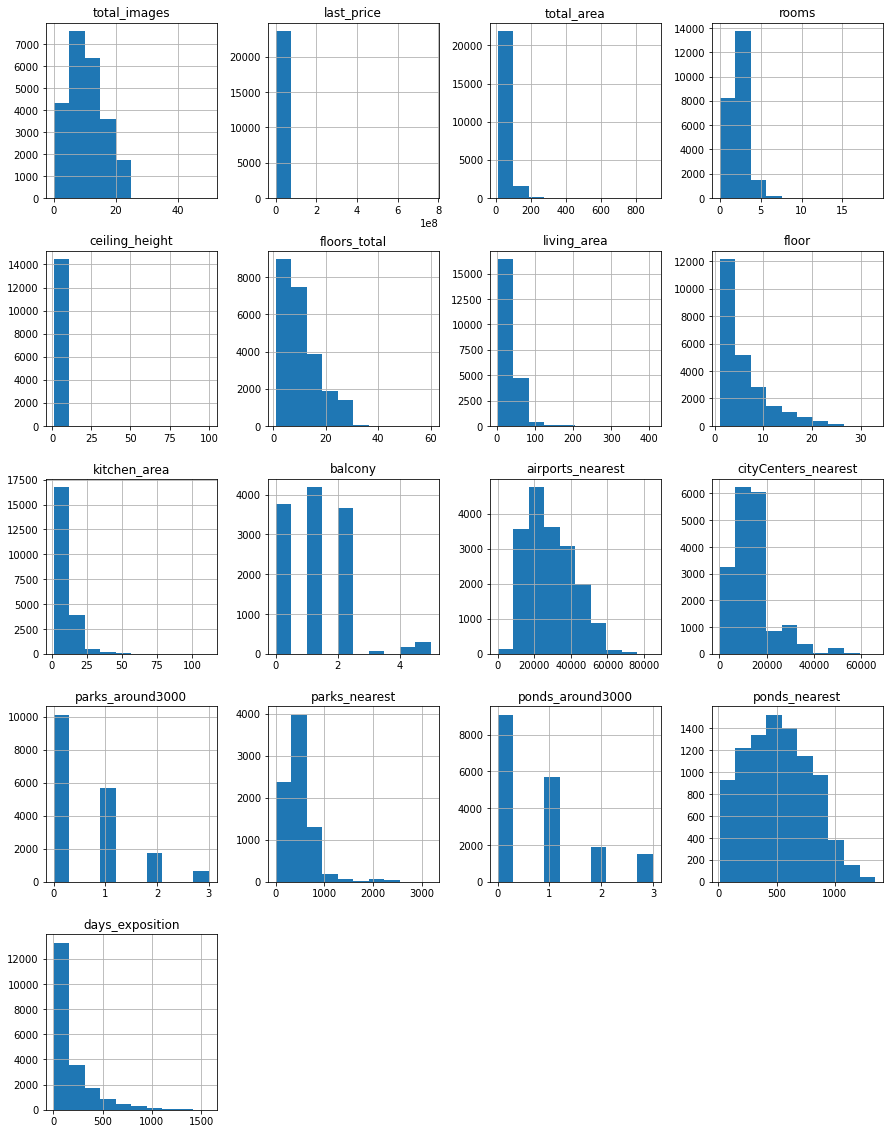

In [6]:
data.hist(figsize=(15, 20));

### Предобработка данных

In [7]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Самое большое количество пропусков в is_apartment - видим очень много пропусков. Апартаменты-от англ. слова квартира... Взглянув на малую площадь, не свойственную частным домам, предположим, что это квартиры и заполним пропуски.

В столбцах parks_nearest, ponds_nearest - возможно, что данные просто не были выгружены системой. Беря в расчет то, что это далеко не самые важные параметры, и отсутствие возможности проставить какое-либо адекватные расстояние, которое не испортит статистику по уже присутствующим данным по этим столбцам, предлагаю здесь не трогать пропуски.

balcony - вполне возможно, что где балкон отсутствует, там вместо 0 стоит NaN. 

В airports_neare и cityCenters_nearest - отсутствует информация или она удалена. Оставим как есть.

ceiling_height - довольно важная информация, но она полна аномалии в виде потолков до 100м. Возможно были перебои при выгрузке. Логично предположить, что на самом деле это вещественные значения: 2.5 м и 3.2 м

days_exposition - довольно важный параметр. Информация может отсутствовать, например, по причине того, что неизвестно когда было закрыто объявление о продаже, т.е., фактически, сделка была совершена, но не была закрыта на онлайн-ресурсе. По той же причине можем получить результаты в виде срока продажи квартиры в несколько лет. Тем не менее, проставлять информацию о сроках продажи наугад не стоит. Здесь "среднее"/"медиана" не подойдут. Можно было бы посмотреть, как продавались квартиры с теми же параметрами, но кто знает, может, в какой-то из квартир трубы текут и воняет, что может сильно влиять на конечный срок продажи, а этих данных в таблице уже нет. Поэтому оставляем этот столбец в покое.

**Заполняем пропуски в data['is_apartment']**

In [8]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

In [9]:
print('Количество NaN', data['is_apartment'].isna().sum())
data['is_apartment'].value_counts()

Количество NaN 20924


False    2725
True       50
Name: is_apartment, dtype: int64

Взглянув на малую площадь, не свойственную частным домам, предположим, что это квартиры и заполним пропуски.

In [10]:
data['is_apartment']=data['is_apartment'].fillna(True)
data['is_apartment']=data['is_apartment'].astype('bool')
data['is_apartment'].isna().sum() #проверяем остались ли пропуски

0

**Заполняем пропуски в data['balcony']**

In [11]:
data['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

In [12]:
print('Количество NaN', data['balcony'].isna().sum())
data['balcony'].value_counts()

Количество NaN 11519


1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

balcony - где данные отсутствуют, проставим нули - балкон отсутствует.

In [13]:
data['balcony']=data['balcony'].fillna(0)
data['balcony'].unique() #проверяем остались ли пропуски

array([0., 2., 1., 5., 4., 3.])

**Заменяем неявные дубликаты в data['locality_name']**

In [14]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Видим много дубликатов типа: "поселок-посёлок". Типичный пропуск... Частенько при электронном написании буква "ё" игнорируется пользователями. Сама так же грешу:))

In [15]:
data['locality_name'].describe()

count               23650
unique                364
top       Санкт-Петербург
freq                15721
Name: locality_name, dtype: object

364 уникальных значений. Посмотрим сколько останется после замены дубликатов.

In [16]:
data['locality_name']=data['locality_name'].str.replace('поселок', 'посёлок') #заменяем все неявные дубликаты

In [17]:
data['locality_name'].unique() #проверяем

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'посёлок городского типа Красный Бор', 'Гатчина',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'посёлок Молодцово',
       'посёлок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'посёлок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'посёлок Торковичи', 'посёлок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет

In [18]:
data['locality_name'].describe() #было 364 уникальных значении, стало 330

count               23650
unique                330
top       Санкт-Петербург
freq                15721
Name: locality_name, dtype: object

было 364 уникальных значении, стало 330. Просмотрим таблицу на наличие еще каких-либо неявных дубликатов и идем дальше...

**Устраняем редкие и выбивающиеся значения в data['ceiling_height']**

In [19]:
print('Количество NaN', data['ceiling_height'].isna().sum())
data['ceiling_height'].value_counts()
data['ceiling_height'].describe()

Количество NaN 9195


count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [20]:
data.loc[data['ceiling_height'] > 10, 'ceiling_height']=\
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] / 10
data['ceiling_height'].describe()

count    14504.000000
mean         2.728100
std          0.299855
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         10.000000
Name: ceiling_height, dtype: float64

In [21]:
data['ceiling_height'].unique()

array([ 2.7 ,   nan,  3.03,  2.5 ,  2.67,  2.56,  3.05,  2.75,  2.6 ,
        2.9 ,  2.8 ,  2.55,  3.  ,  2.65,  3.2 ,  2.61,  3.25,  3.45,
        2.77,  2.85,  2.64,  2.57,  4.15,  3.5 ,  3.3 ,  2.71,  4.  ,
        2.47,  2.73,  2.84,  3.1 ,  2.34,  3.4 ,  3.06,  2.72,  2.54,
        2.51,  2.78,  2.76,  2.58,  3.7 ,  2.52,  5.2 ,  2.87,  2.66,
        2.59,  2.  ,  2.45,  3.6 ,  2.92,  3.11,  3.13,  3.8 ,  3.15,
        3.55,  3.16,  3.62,  3.12,  2.53,  2.74,  2.96,  2.46,  5.3 ,
        5.  ,  2.79,  2.95,  4.06,  2.94,  3.82,  3.54,  3.53,  2.83,
        4.7 ,  2.4 ,  3.38,  3.01,  5.6 ,  3.65,  3.9 ,  3.18,  3.35,
        2.3 ,  3.57,  2.48,  2.62,  2.82,  3.98,  2.63,  3.83,  3.52,
        3.95,  3.75,  2.88,  3.67,  3.87,  3.66,  3.85,  3.86,  4.19,
        3.24,  4.8 ,  4.5 ,  4.2 ,  3.36,  3.08,  3.68,  3.07,  3.37,
        3.09,  8.  ,  3.26,  3.34,  2.81,  3.44,  2.97,  3.14,  4.37,
        2.68,  3.22,  3.27,  4.1 ,  2.93,  3.46,  3.47,  3.33,  3.63,
        3.32,  1.2 ,

In [22]:
print('Количество NaN', data['living_area'].isna().sum())
data['living_area'].describe()

Количество NaN 1903


count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [23]:
data.loc[data['living_area'] > 50, 'living_area'] = \
data.loc[data['living_area'] > 50, 'living_area'] / 10

In [24]:
data['kitchen_area'].unique()

array([ 25.  ,  11.  ,   8.3 ,    nan,  41.  ,   9.1 ,  14.4 ,  18.9 ,
         8.81,   6.5 ,   8.5 ,   6.  ,   9.  ,   5.2 ,   8.  ,   7.6 ,
         5.6 ,  12.  ,   5.7 ,   6.1 ,  19.6 ,  15.  ,   7.  ,   9.2 ,
        11.7 ,  13.4 ,  17.  ,   6.3 ,  11.6 ,   8.8 ,  10.  ,  17.6 ,
         7.5 ,   9.5 ,  50.  ,  15.5 ,  10.7 ,  11.1 ,  20.  ,  11.9 ,
        16.  ,   5.3 ,  11.5 ,   7.2 ,   6.2 ,  10.4 ,   7.1 ,   4.9 ,
         7.3 ,  11.95,  10.2 ,   6.4 ,   5.5 ,  13.  ,   8.4 ,  23.6 ,
        10.8 ,  18.3 ,   5.  ,   8.2 ,  24.  ,  23.8 ,   6.6 ,  26.85,
        15.4 ,   7.8 ,  33.8 ,   5.4 ,  12.72,  12.2 ,  19.  ,  12.4 ,
         7.9 ,  10.3 ,   9.8 ,  17.5 ,  14.7 ,  20.91,  21.3 ,  10.6 ,
        10.9 ,   9.7 ,   7.7 ,  12.5 ,  11.4 ,   8.6 ,  11.24,  14.1 ,
        15.7 ,  13.29,  14.  ,  12.9 ,  12.7 ,  16.5 ,   9.36,  21.5 ,
        35.  ,  10.5 ,   8.7 ,  19.3 ,  21.4 ,  40.  ,  49.2 ,  11.52,
         8.9 ,   9.6 ,  30.  ,  14.2 ,   8.1 ,  10.44,   4.5 ,  16.3 ,
      

Определенно, площадь комнаты не бывает 274-400м2. Явно, это аномалии. Нужно поменять расположение точки после цифр.

In [25]:
data.query('rooms == 0')[['kitchen_area', 'living_area']].isnull().sum()


kitchen_area    197
living_area      14
dtype: int64

Лишь малая часть пропусков по этим столбцам относится к студиям. Да и с ними нам нечего делать - не делить же пополам общую площадь. Оставляем как есть.

In [26]:
print('Количество NaN', data['kitchen_area'].isna().sum())
#data['kitchen_area'].describe()
#data['kitchen_area'].unique()

Количество NaN 2278


И тут аномалии такого же характера, что и выше. Видимо в какой-то момент данные исказились, возможно при разгрузке.

In [27]:
data.loc[data['kitchen_area'] > 50, 'kitchen_area'] = \
data.loc[data['kitchen_area'] > 50, 'kitchen_area'] / 10

In [28]:
data['kitchen_area'].unique()

array([25.  , 11.  ,  8.3 ,   nan, 41.  ,  9.1 , 14.4 , 18.9 ,  8.81,
        6.5 ,  8.5 ,  6.  ,  9.  ,  5.2 ,  8.  ,  7.6 ,  5.6 , 12.  ,
        5.7 ,  6.1 , 19.6 , 15.  ,  7.  ,  9.2 , 11.7 , 13.4 , 17.  ,
        6.3 , 11.6 ,  8.8 , 10.  , 17.6 ,  7.5 ,  9.5 , 50.  , 15.5 ,
       10.7 , 11.1 , 20.  , 11.9 , 16.  ,  5.3 , 11.5 ,  7.2 ,  6.2 ,
       10.4 ,  7.1 ,  4.9 ,  7.3 , 11.95, 10.2 ,  6.4 ,  5.5 , 13.  ,
        8.4 , 23.6 , 10.8 , 18.3 ,  5.  ,  8.2 , 24.  , 23.8 ,  6.6 ,
       26.85, 15.4 ,  7.8 , 33.8 ,  5.4 , 12.72, 12.2 , 19.  , 12.4 ,
        7.9 , 10.3 ,  9.8 , 17.5 , 14.7 , 20.91, 21.3 , 10.6 , 10.9 ,
        9.7 ,  7.7 , 12.5 , 11.4 ,  8.6 , 11.24, 14.1 , 15.7 , 13.29,
       14.  , 12.9 , 12.7 , 16.5 ,  9.36, 21.5 , 35.  , 10.5 ,  8.7 ,
       19.3 , 21.4 , 40.  , 49.2 , 11.52,  8.9 ,  9.6 , 30.  , 14.2 ,
        8.1 , 10.44,  4.5 , 16.3 , 11.2 , 18.4 ,  7.4 , 11.3 ,  9.4 ,
       13.1 , 10.19,  7.06, 22.  , 36.  ,  5.1 , 18.7 ,  9.9 , 14.3 ,
       18.  , 23.  ,

In [29]:
print('Количество NaN', data['airports_nearest'].isna().sum())
data['airports_nearest'].value_counts()

Количество NaN 5542


37434.0    61
21928.0    32
39946.0    30
44870.0    30
18732.0    27
           ..
53478.0     1
20335.0     1
33699.0     1
26945.0     1
20875.0     1
Name: airports_nearest, Length: 8275, dtype: int64

Большое количество пропусков соответствует сельской местности, предполагаю, что в данных террирория нет аэропортов. Поэтому эти данные не восстановишь. Оставим как есть.

In [30]:
print('Количество NaN', data['cityCenters_nearest'].isna().sum())
data['cityCenters_nearest'].value_counts()

Количество NaN 5519


8460.0     61
20802.0    32
10720.0    30
8434.0     27
20444.0    27
           ..
5278.0      1
11575.0     1
3205.0      1
12747.0     1
4234.0      1
Name: cityCenters_nearest, Length: 7642, dtype: int64

Там где нет аэропортов, соответственно нет и близ лежащих городов. Не восстановить.

In [31]:
print('Количество NaN', data['days_exposition'].isna().sum())
data['days_exposition'].value_counts()

Количество NaN 3181


45.0      880
60.0      538
7.0       234
30.0      208
90.0      204
         ... 
969.0       1
1.0         1
1147.0      1
1148.0      1
1174.0      1
Name: days_exposition, Length: 1141, dtype: int64

Точный день публикации объявления восстановить не получится никак. Разве что обратиться к ясновидящим)))

**Со столбцами с пропусками разобрались. Теперь на всякий случай проверим на выбросы следующих важных для анализа столбцов: 
    total_area, last_price, rooms**

<AxesSubplot:>

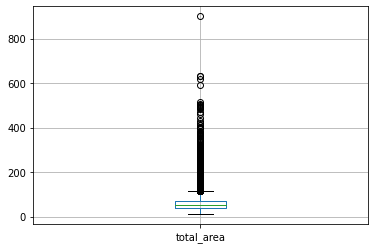

In [32]:
data.boxplot(column='total_area')

Определяем границы: 20 - 140м2. По диаграмме размаха видим, что аномальные значения (отбросы) - выше 500м2. Удалим их.

In [33]:
data['total_area']=data.query('total_area < 500')['total_area']

In [34]:
data['total_area'].value_counts()

45.00     419
42.00     383
60.00     347
31.00     346
44.00     345
         ... 
44.24       1
56.85       1
37.92       1
115.60      1
55.06       1
Name: total_area, Length: 2174, dtype: int64

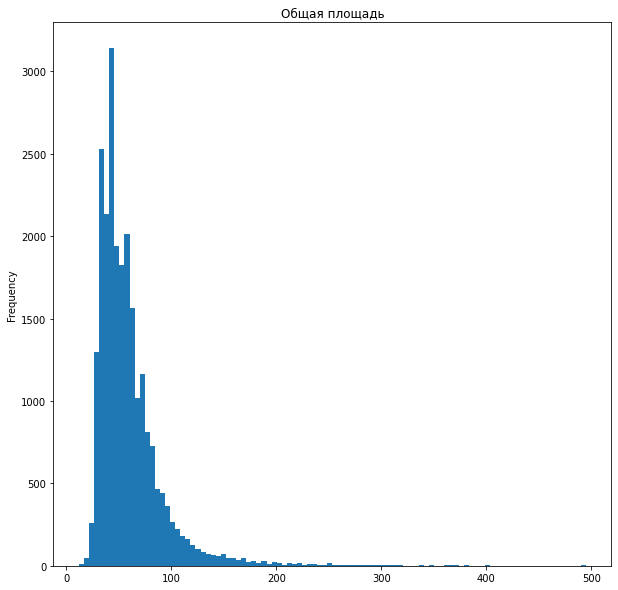

In [35]:
data['total_area'].plot(bins=100, title='Общая площадь', kind='hist', figsize=(10,10));

Общая площадь продаваемых квартир в основном составляет - 50-60м2 - более 6000 объявлении. Потом идут квартиры примерно - 70-80м2. Есть и квартиры 400м2 и более, но их количество мало. 

***Избавимся от отбросов в столбце last_price***

<AxesSubplot:>

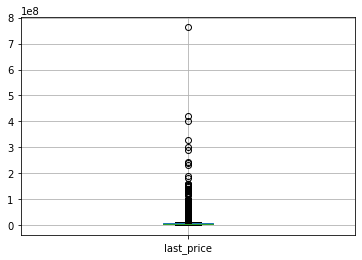

In [36]:
data.boxplot(column='last_price')

In [37]:
data['last_price'].value_counts()

4500000.0     342
3500000.0     291
4000000.0     260
4300000.0     260
4200000.0     259
             ... 
10430000.0      1
9917600.0       1
3180500.0       1
7297000.0       1
4386000.0       1
Name: last_price, Length: 2978, dtype: int64

***Избавимся от отбросов в столбце last_price***

<AxesSubplot:>

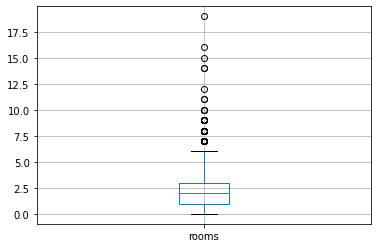

In [38]:
data.boxplot(column='rooms')

Определяем границы: rooms - 0-6 комнат; Медиана - 2; Далее избавимся от отбрсов выше 12 этажа.

In [ ]:
data['rooms']=data.query('rooms < 12')['rooms']

Проверим какое количество данных мы в итоге отбросили:

In [40]:
old_data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
new_data = data
new_data.shape[0] / old_data.shape[0]

1.0

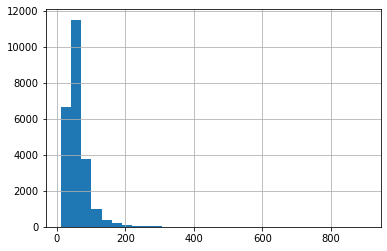

In [41]:
#код ревьюера
data2 = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
(data2['total_area']).hist(bins=30);

 ### Посчитайте и добавьте в таблицу новые столбцы

Добавим новые столбцы: 
-цена за м2;
-год публикации;
-месяц публикации;
-день публикации;
-первый этаж;
-второй этаж;
-расстояние до аэропорта в км;

In [42]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  9
first_day_exposition        0
rooms                       6
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [43]:
data['m2_price']= (data['last_price'] / data ['total_area'] / 1000).round()
print(data.head(10))

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00  2019-03-07T00:00:00    3.0   
1             7   3350000.0       40.40  2018-12-04T00:00:00    1.0   
2            10   5196000.0       56.00  2015-08-20T00:00:00    2.0   
3             0  64900000.0      159.00  2015-07-24T00:00:00    3.0   
4             2  10000000.0      100.00  2018-06-19T00:00:00    2.0   
5            10   2890000.0       30.40  2018-09-10T00:00:00    1.0   
6             6   3700000.0       37.30  2017-11-02T00:00:00    1.0   
7             5   7915000.0       71.60  2019-04-18T00:00:00    2.0   
8            20   2900000.0       33.16  2018-05-23T00:00:00    1.0   
9            18   5400000.0       61.00  2017-02-26T00:00:00    3.0   

   ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
0            2.70          16.0         5.10      8          True   False   
1             NaN          11.0        18.60      1          Tru

In [44]:
data['first_day_exposition']=pd.to_datetime(
data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['first_day_exposition']

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23699, dtype: datetime64[ns]

***Добавим год публикации объявления***

In [45]:
data['year'] = data['first_day_exposition'].dt.year
data['year']

0        2019
1        2018
2        2015
3        2015
4        2018
         ... 
23694    2017
23695    2018
23696    2018
23697    2017
23698    2017
Name: year, Length: 23699, dtype: int64

***Добавим месяц публикации объявления***

In [46]:
data['month'] = data['first_day_exposition'].dt.month
data['month']

0         3
1        12
2         8
3         7
4         6
         ..
23694     3
23695     1
23696     2
23697     3
23698     7
Name: month, Length: 23699, dtype: int64

***Добавим день недели публикации объявления:***

In [47]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['weekday']

0        3
1        1
2        3
3        4
4        1
        ..
23694    1
23695    0
23696    6
23697    1
23698    4
Name: weekday, Length: 23699, dtype: int64

***Добавим новый стобец с первыми и другими этажами***

In [48]:
import numpy as np
data['etaj']= np.where(data['floor'] == 1, 'первый', 'другой')
data['etaj'].value_counts()

другой    20782
первый     2917
Name: etaj, dtype: int64

***Добавим новый стобец с последним и другими этажами***

In [49]:
data['etaj'] = np.where(data['floor'] == data['floors_total'], 'последний', data['etaj'])
data['etaj'].value_counts()

другой       17446
последний     3361
первый        2892
Name: etaj, dtype: int64

***расстояние до центра города в километрах***

In [50]:
data.loc[:, 'cityCenters_nearest_km'] = (data.loc[:, 'cityCenters_nearest']/1000).round()
data['cityCenters_nearest_km'] 

0        16.0
1        19.0
2        14.0
3         7.0
4         8.0
         ... 
23694     4.0
23695     NaN
23696     NaN
23697    10.0
23698     NaN
Name: cityCenters_nearest_km, Length: 23699, dtype: float64

### Проведите исследовательский анализ данных

In [51]:
data.head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,m2_price,year,month,weekday,etaj,cityCenters_nearest_km
0,20,13000000.0,108.00,2019-03-07,3.0,2.70,16.0,5.10,8,True,False,False,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120.0,2019,3,3,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1.0,NaN,11.0,18.60,1,True,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,83.0,2018,12,1,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2.0,NaN,5.0,34.30,4,True,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,93.0,2015,8,3,другой,14.0
3,0,64900000.0,159.00,2015-07-24,3.0,NaN,14.0,NaN,9,True,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408.0,2015,7,4,другой,7.0
4,2,10000000.0,100.00,2018-06-19,2.0,3.03,14.0,32.00,13,True,False,False,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100.0,2018,6,1,другой,8.0
5,10,2890000.0,30.40,2018-09-10,1.0,NaN,12.0,14.40,5,True,False,False,9.10,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95.0,2018,9,0,другой,NaN
6,6,3700000.0,37.30,2017-11-02,1.0,NaN,26.0,10.60,6,True,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99.0,2017,11,3,другой,19.0
7,5,7915000.0,71.60,2019-04-18,2.0,NaN,24.0,NaN,22,True,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,111.0,2019,4,3,другой,12.0
8,20,2900000.0,33.16,2018-05-23,1.0,NaN,27.0,15.43,26,True,False,False,8.81,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,87.0,2018,5,2,другой,NaN
9,18,5400000.0,61.00,2017-02-26,3.0,2.50,9.0,43.60,7,True,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,89.0,2017,2,6,другой,15.0


In [52]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,m2_price,year,month,weekday,cityCenters_nearest_km
count,23699.000000,2.369900e+04,23690.000000,23693.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,23699.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000,23690.000000,23699.000000,23699.000000,23699.000000,18180.000000
mean,9.858475,6.541549e+06,60.143878,2.067362,2.728100,10.673824,25.509223,5.892358,10.441897,0.591080,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634,99.353187,2017.367146,6.400101,2.569307,14.184818
std,5.682529,1.088701e+07,33.998196,1.058170,0.299855,6.597173,12.138199,4.885249,5.265121,0.959298,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988,50.113631,1.039771,3.491561,1.789082,8.616194
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,0.000000,2014.000000,1.000000,0.000000,0.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.510000,5.000000,17.000000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000,77.000000,2017.000000,3.000000,1.000000,9.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,26.100000,4.000000,9.100000,0.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000,95.000000,2017.000000,6.000000,3.000000,13.000000
75%,14.000000,6.800000e+06,69.787500,3.000000,2.800000,16.000000,34.200000,8.000000,12.000000,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000,114.000000,2018.000000,10.000000,4.000000,16.000000
max,50.000000,7.630000e+08,495.000000,11.000000,10.000000,60.000000,50.000000,33.000000,50.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,1908.000000,2019.000000,12.000000,6.000000,66.000000


***Предварительный анализ выдает следующее:***
Минимальная площадь квартиры -12м2, возможно это офисное помещение. Но среднее значение выглядит более здравым;
по цене за квартиру - есть варианты и за 12 тысяч рублей, есть за 763 млн, любой покупатель найдет свой вариант;
число комнат - от 0 (студия) до 19. Возможно, это общежития или нежилые помещения;

***Теперь к каждому параметру по отдельности:***

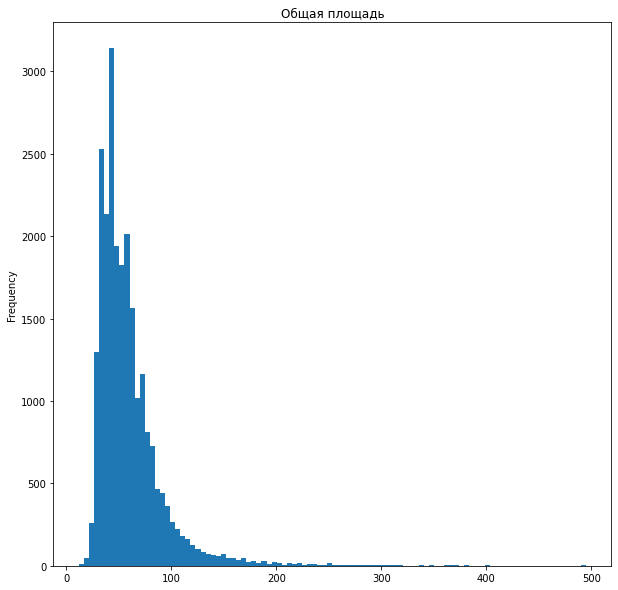

In [53]:
data['total_area'].plot(bins=100, title='Общая площадь', kind='hist', figsize=(10,10));

Общая площадь продаваемых квартир в основном составляет - 50-60м2 - более 6000 объявлении. Потом идут квартиры примерно - 70-80м2. Есть и квартиры 400м2 и более, но их количество мало. 

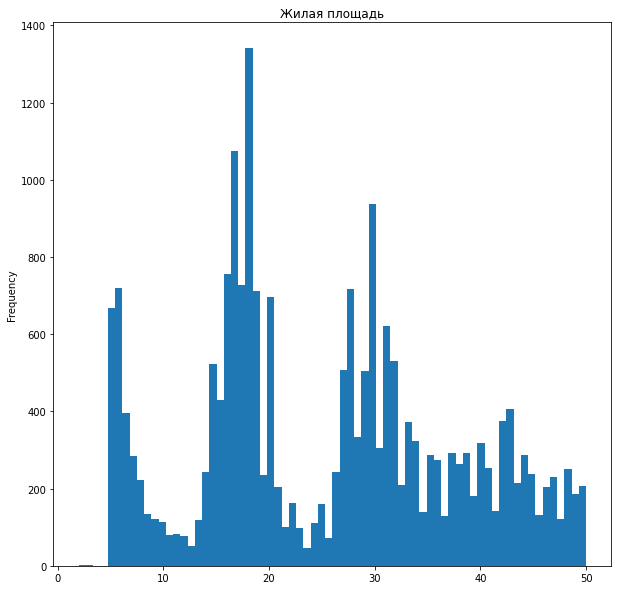

In [54]:
data['living_area'].plot(bins=70, kind='hist', title='Жилая площадь', figsize=(10,10));

Большинство жилой площади равно примерно 15-20м2. В среднем - 35м2. Начиная от 50м2 показатель начинает снижаться. Значит квартиры с жилой площадью менее 50м2, более востребованы.

In [55]:
data['kitchen_area'].describe()

count    21421.000000
mean        10.441897
std          5.265121
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max         50.000000
Name: kitchen_area, dtype: float64

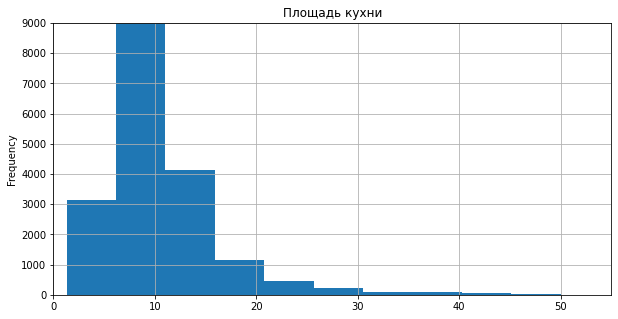

In [56]:
data['kitchen_area'].plot(kind='hist', xlim=(0,55), ylim=(0,9000), title='Площадь кухни', grid=True, figsize=(10, 5));

Пик цены для площадей кухни от 5-12м2, следующий рост цены замечен от 13-16м2. 

In [57]:
data['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

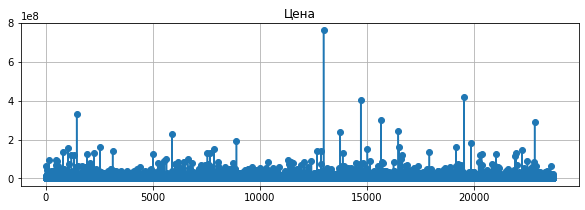

In [58]:
data['last_price'].plot(style='o-', grid=True, title='Цена', figsize=(10, 3));

Большая часть квартир продается за цену в промежутке между 3 и 6 млн.

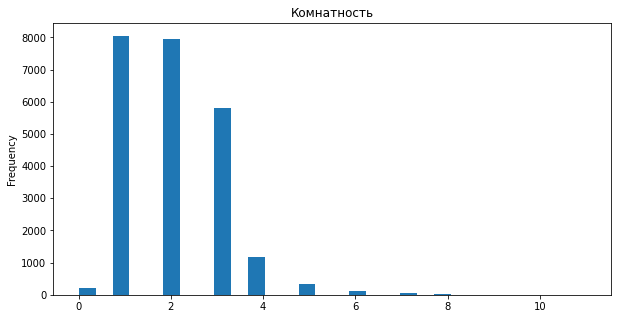

In [59]:
data['rooms'].plot(kind='hist', bins=30, title='Комнатность', figsize=(10,5));

В основном на продажу выставлены 2-3-1комнатные квартиры, редко 4 комнат и более.

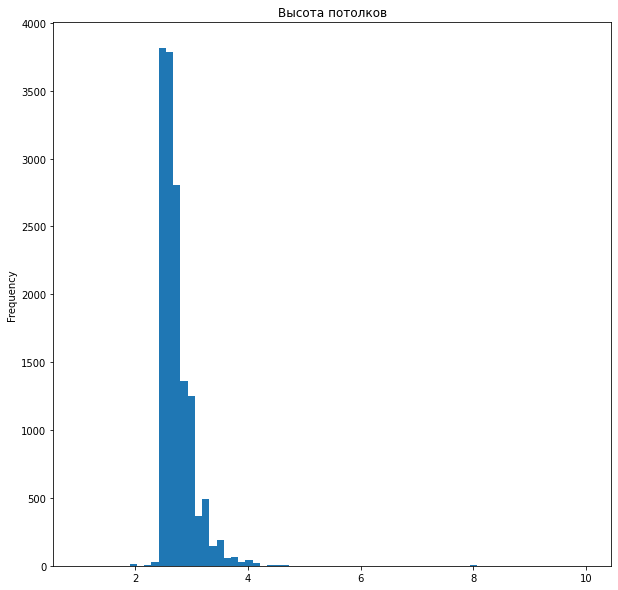

In [60]:
data['ceiling_height'].plot(kind='hist', title='Высота потолков', bins=70, figsize=(10,10));

Тут наглядно понятно, в стандратной кваритире высота потолков - 2.8-3-3.3м высокая. Это из-за большого количества квартир с такой стандартной высотой.

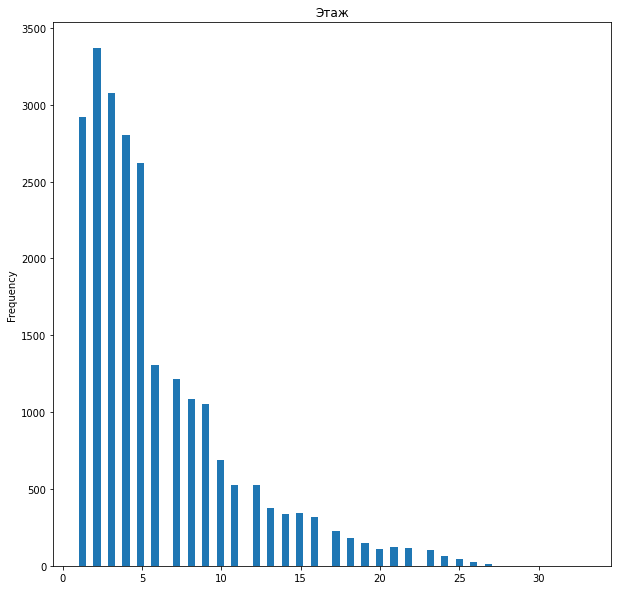

In [61]:
data['floor'].plot(kind='hist', title='Этаж',bins=70, figsize=(10,10));

В нашей выборке большинство квартир находятся на 2-3-1-4-5м этажах соответственно. Далее идет спад. 

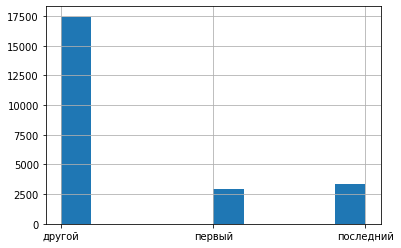

In [62]:
data['etaj'].hist();

Много квартир не на первом, так и не на последних этажах

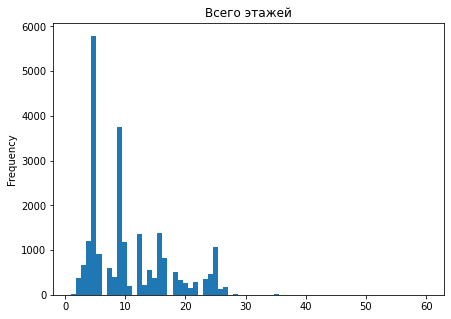

In [63]:
data['floors_total']. plot(kind='hist', title='Всего этажей', bins=70, figsize=(7,5));

Во многих объявлениях всего этажей 2-3. 

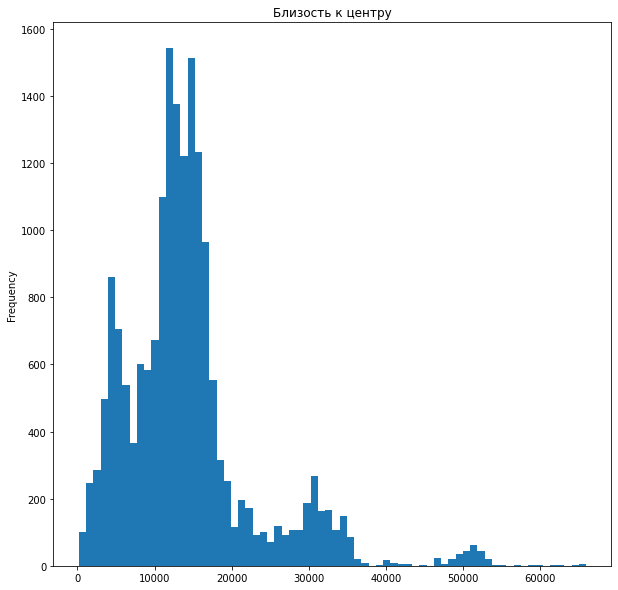

In [64]:
data['cityCenters_nearest'].plot(kind='hist', title='Близость к центру',bins=70, figsize=(10,10));

Большинство объявлении размещено близ к центру (примерно 1700км от города). Чем дальше, тем объявлении меньше.

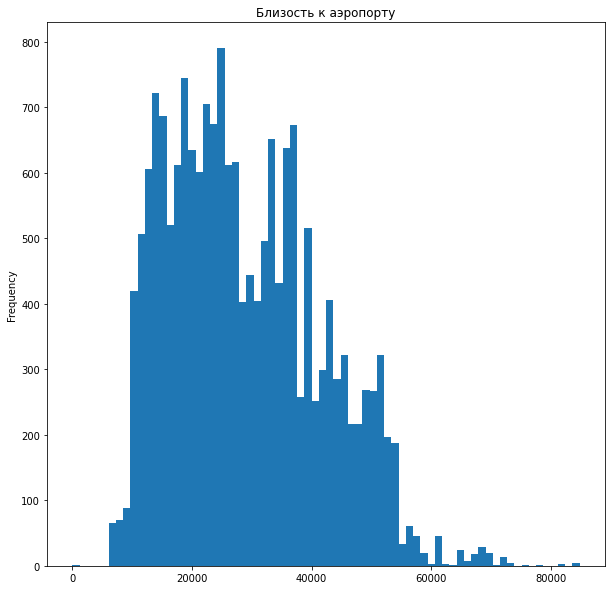

In [65]:
data['airports_nearest'].plot(kind='hist', title='Близость к аэропорту',bins=70, figsize=(10,10));

Чуть дальше 20тыс км от аэропорта не так близко к аэропорту в основном расположены продаваемые квартиры. Чем дальше, тем объявлении меньше.

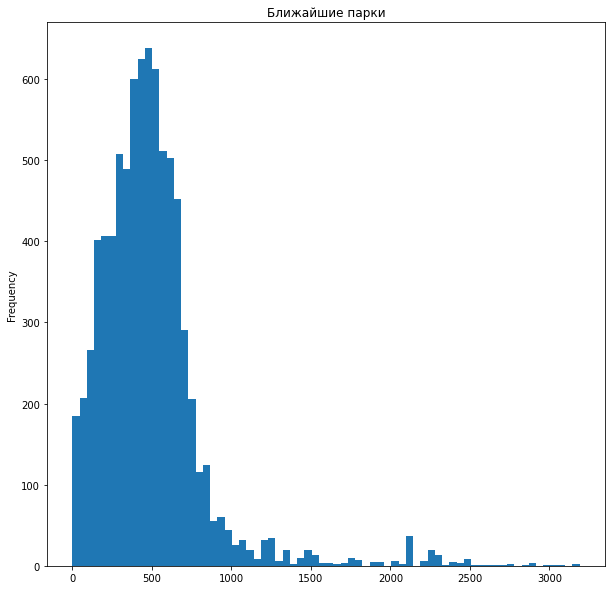

In [66]:
data['parks_nearest'].plot(kind='hist', title='Ближайшие парки', bins=70, figsize=(10,10));

По этой гистограмме видно, что в Петербурге много парков рядом с высотками.

In [67]:
data['weekday'].describe()

count    23699.000000
mean         2.569307
std          1.789082
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: weekday, dtype: float64

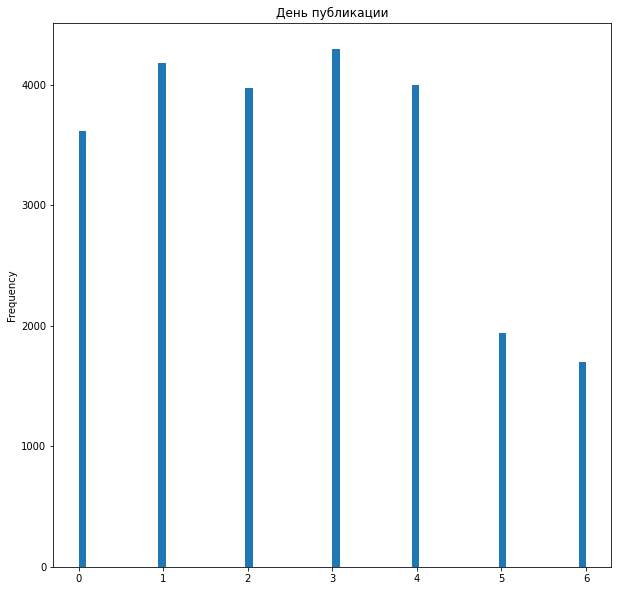

In [68]:
data['weekday'].plot(kind='hist', title='День публикации', bins=70, figsize=(10,10));

В основном люди публикуют объявления в будние дни. Особенно по вторникам и четвергам. В выходные почти в два раза меньше объявлений.

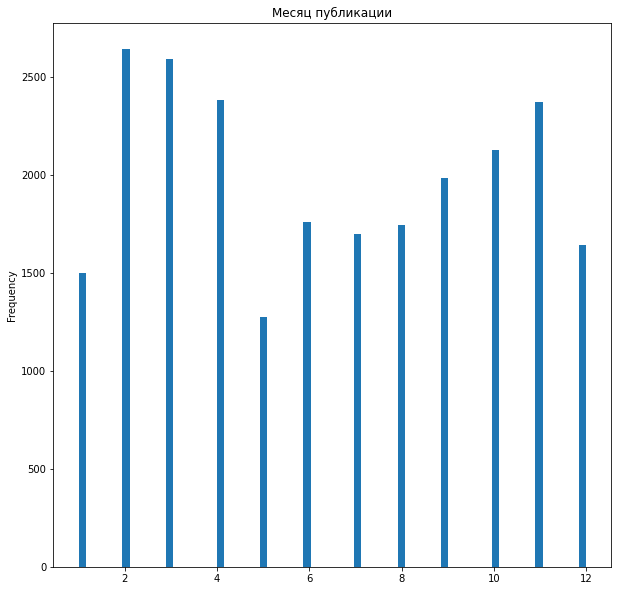

In [69]:
data['month'].plot(kind='hist', title='Месяц публикации',bins=70, figsize=(10,10));

Люди ставят дом на продажу чаще с марта по май, в начале лета показатели падают вдвое, но в июле начинается рост количества объявлений, который падает в декабре, видимо в связи с праздниками.

**Посморим как быстро продовались квартиры**

In [70]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

В среднем квартиры продавались 180дней. Самая быстрая продажа-1день. Самая долгая продажа составила -4года (возможно и вправду были проблемы с продажей, а возможно, хозяин просто забыл убрать объявление). 

In [71]:
data['days_exposition'].median()

95.0

Медианное время продажи -95дней, это три месяца, неплохой показатель.

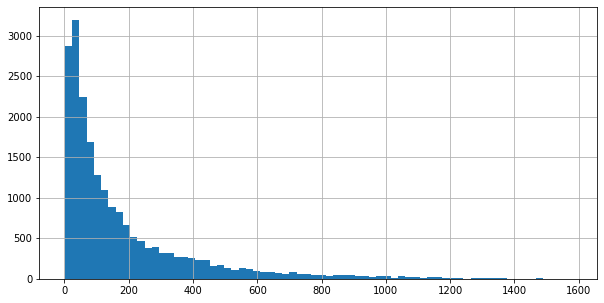

In [72]:
data['days_exposition'].hist(bins=70, figsize=(10,5));

Большая часть квартир продавалась в течении 50-100 дней. Есть и квартиры, которые продавались год и более, но их количество намного меньше, чем дольше, тем меньше.

***Факторы влияющие на полную стоимость квартиры***

***Зависимость общей площади на цену***

In [73]:
data.pivot_table(index='total_area', values='last_price', aggfunc=['median', 'mean'])

,median,mean
,last_price,last_price
total_area,,
12.0,2400000.0,2400000.0
13.0,1850000.0,2350000.0
13.2,1686000.0,1686000.0
14.0,1190000.0,1190000.0
15.0,1725000.0,1725000.0
...,...,...
483.9,49950000.0,49950000.0
488.0,99000000.0,99000000.0


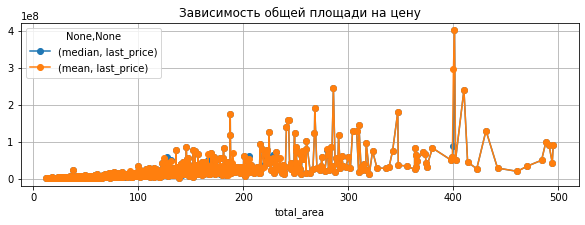

In [74]:
data.pivot_table(index='total_area', values='last_price', aggfunc=['median', 'mean']).plot(title='Зависимость общей площади на цену', style='o-', grid=True, figsize=(10, 3)); 

В среднем цена на общую площадь растет пропорционально, однако наблюдается пик роста цены на площади: 180м2, 400м2, 600 и 900м2.

***Зависимость жилой площади на цену***

In [75]:
data.pivot_table(index='living_area', values='last_price', aggfunc=['median', 'mean', 'count'])

,median,mean,count
,last_price,last_price,last_price
living_area,,,
2.000,4340000.0,4.340000e+06,2
3.000,34715000.0,3.471500e+07,2
5.000,2680000.0,2.680000e+06,1
5.002,11507200.0,1.150720e+07,1
5.008,8500000.0,8.500000e+06,1
...,...,...,...
49.800,8700000.0,7.539123e+06,10
49.870,7650000.0,7.650000e+06,1


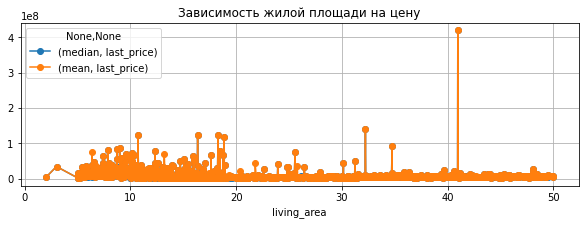

In [76]:
data.pivot_table(index='living_area', values='last_price', aggfunc=['median', 'mean']).plot(title='Зависимость жилой площади на цену', style='o-', grid=True, figsize=(10, 3)); 

В среднем цена на жилую площадь растет пропорционально, однако наблюдается пик роста цены на площади: 40м2

***Зависимость площади кухни на цену***

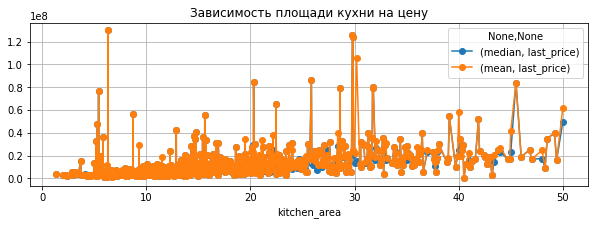

In [77]:
data.pivot_table(index='kitchen_area', values='last_price', aggfunc=['median', 'mean']).plot(title='Зависимость площади кухни на цену', style='o-', grid=True, figsize=(10, 3)); 

Площадь кухни 7м2 и 30м2 оцениваются высоко. 

***Зависимость количества комнат на цену***

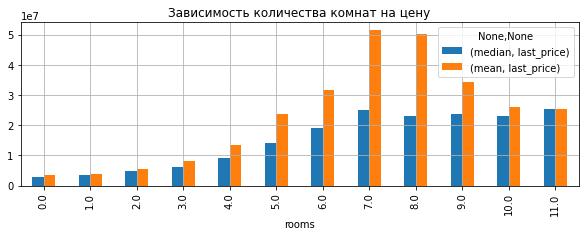

In [78]:
data.pivot_table(index='rooms', values='last_price', aggfunc=['median', 'mean']).plot(title='Зависимость количества комнат на цену', kind='bar', grid=True, figsize=(10, 3)); 

Странно, что самые дорогие квартиры имеют 12 комнат - это выбросы. Чем больше комнат, тем выше цена - так продолжается до 7 комнат. Далее - единичные значения (выбросы). Вполне возможно, что дальше идут бывшие коммуналки на продажу.

***Зависимость типа этажа на цену***

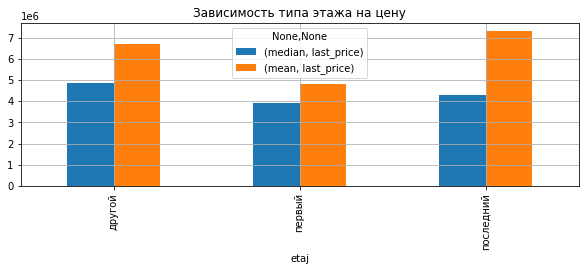

In [79]:
data.pivot_table(index='etaj', values='last_price', aggfunc=['median', 'mean']).plot(title='Зависимость типа этажа на цену', kind='bar', grid=True, figsize=(10, 3)); 

Цены на квартиры на 1ом этаже в среднем на %20 ниже, чем цены на квартиры, расположенные на других этажах, кроме последнего. На последнем этаже, конечно, подороже, чем на 1ом, но дешевле чем на других.

***Зависимость даты размещения (день недели, месяц, год) на цену***

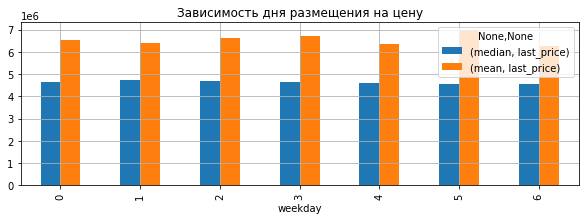

In [80]:
data.pivot_table(index='weekday', values='last_price', aggfunc=['median', 'mean']).plot(title='Зависимость дня размещения на цену', kind='bar', grid=True, figsize=(10, 3));

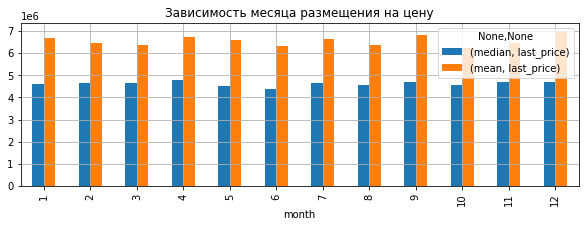

In [81]:
data.pivot_table(index='month', values='last_price', aggfunc=['median', 'mean']).plot(title='Зависимость месяца размещения на цену', kind='bar', grid=True, figsize=(10, 3)); 

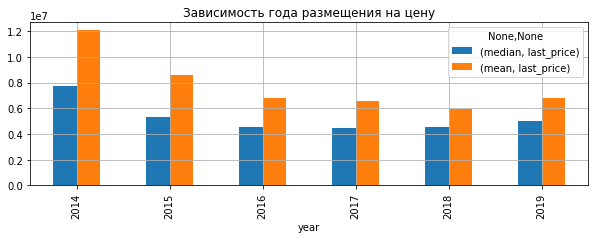

In [82]:
data.pivot_table(index='year', values='last_price', aggfunc=['median', 'mean']).plot(title='Зависимость года размещения на цену', kind='bar', grid=True, figsize=(10, 3)); 

зависимость цены от дня недели публикации практически никак не зависит. Единственное, что можно сказать, так это то, что в среднем цены на квартиры, объявление о продажи которых опубликовано в будний день, чуть выше, чем цена на квартиры с объявлениями, опубликованными в выходные дни;

зависимость цены от месяца публикации - апрель оказался самым "деловым": цены на квартиры, чьи объявления о продаже были опубликованы в апреле, выше, чем по остальным месяцам. Особенно выделяется медиана цен на квартиры по июньским объявлениям - довольно низкие в сравнении с другими месяцами;

зависимость цены от года публикации - 2014г. тут очень выделяется. А в основном виден гибкий спад цены на недвижимость.

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v1:</b>
<br>Зависимость цены изучена верно! Ещё тут можно использовать для визуализации pairplot из библиотеки seaborn 
    
    https://seaborn.pydata.org/generated/seaborn.pairplot.html
</div>

***Выберем 10 населённых пунктов с наибольшим числом объявлений. Посчитаем среднюю цену квадратного метра в этих населённых пунктах. Выделим населённые пункты с самой высокой и низкой стоимостью жилья. Данные берем из столбца locality_name.***

In [83]:
top10 = data['locality_name'].value_counts().index.tolist()[:10]
mean10_metrics = [data[data['locality_name'] == city]['m2_price'].median().round(2) for city in top10]
mean10_prices = [data[data['locality_name'] == city]['last_price'].median() for city in top10]
frame = {'Город': top10, 'Средняя цена за кв.м., тыс. руб.': mean10_metrics, 'Средняя цена за квартиру, тыс. руб.': mean10_prices}
dataframe = pd.DataFrame(frame).sort_values(by='Средняя цена за кв.м., тыс. руб.', ascending=False)
dataframe

,Город,"Средняя цена за кв.м., тыс. руб.","Средняя цена за квартиру, тыс. руб."
0,Санкт-Петербург,105.0,5500000.0
4,Пушкин,100.0,5180000.0
6,посёлок Парголово,92.0,4100000.0
8,деревня Кудрово,92.0,3790000.0
1,посёлок Мурино,86.0,3400000.0
2,посёлок Шушары,77.0,3950000.0
5,Колпино,75.0,3600000.0
7,Гатчина,68.0,3100000.0
3,Всеволожск,66.0,3450000.0
9,Выборг,58.0,2897000.0


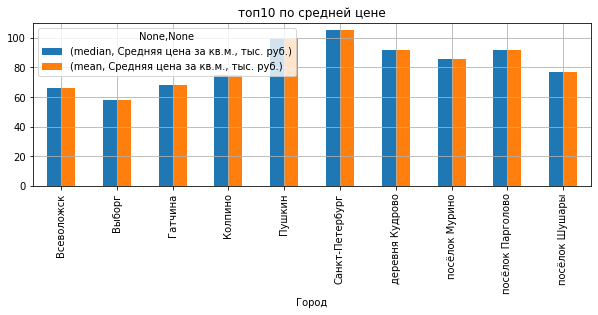

In [84]:
dataframe.pivot_table(index='Город', values='Средняя цена за кв.м., тыс. руб.', aggfunc=['median', 'mean']).plot(title='топ10 по средней цене', style='o-', kind='bar', grid=True, figsize=(10, 3)); 

Как и ожидалось, самые дорогие квартиры (что за всё жилье, что за 1 кв.м.) в Санкт-Петербурге и парковом городе Пушкине. Чем дальше от города, тем дешевле. В Выборге средняя цена за квадратный метр в 2 раз ниже, чем в Санкт-Петербурге.

***Вычислим среднюю цену каждого километра***

Изучим предложения квартир. Для каждой квартиры есть информация о расстоянии до центра. Выделим квартиры в Санкт-Петербурге (locality_name). Задача — выяснить, какая область входит в центр. Создадим столбец с расстоянием до центра в километрах: округлим до целых значений. После этого посчитаем среднюю цену для каждого километра. Построим график: он будет показывать, как цена зависит от удалённости от центра. Определим границу, где график сильно меняется — это и будет центральная зона.

In [85]:
data_spb = data.query('locality_name == "Санкт-Петербург"')
data_spb.loc[:, 'cityCenters_nearest_kms'] = (data_spb.loc[:, 'cityCenters_nearest']/1000).round()
data_spb.head()

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,m2_price,year,month,weekday,etaj,cityCenters_nearest_km,cityCenters_nearest_kms
0,20,13000000.0,108.0,2019-03-07,3.0,2.70,16.0,5.1,8,True,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120.0,2019,3,3,другой,16.0,16.0
2,10,5196000.0,56.0,2015-08-20,2.0,NaN,5.0,34.3,4,True,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,93.0,2015,8,3,другой,14.0,14.0
3,0,64900000.0,159.0,2015-07-24,3.0,NaN,14.0,NaN,9,True,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408.0,2015,7,4,другой,7.0,7.0
4,2,10000000.0,100.0,2018-06-19,2.0,3.03,14.0,32.0,13,True,False,False,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100.0,2018,6,1,другой,8.0,8.0
7,5,7915000.0,71.6,2019-04-18,2.0,NaN,24.0,NaN,22,True,False,False,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,111.0,2019,4,3,другой,12.0,12.0


Строим график медианной цены в зависимости от удаленности от города:

<AxesSubplot:title={'center':'Зависимость от удаленности от города на цену'}, xlabel='cityCenters_nearest_kms'>

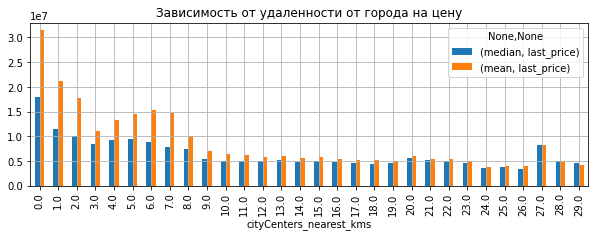

In [86]:
data_spb.pivot_table(index='cityCenters_nearest_kms', values='last_price', aggfunc=['median', 'mean']).plot(title='Зависимость от удаленности от города на цену', kind='bar', grid=True, figsize=(10, 3)) 

Ожидаемо, что в самом центре (в радиусе до 1 км) медианная цена на квартиру стремится к 20 млн р. Если опираться на резкое падение цены по графику, то центр ограничен радиусом в 8 км, далее медианная цена довольно заметно падает. Однако, цены на 4-7км сравнимы с ценами на квартиры, расположенные в 2 км от центра. 

### Общий вывод

- Чем больше площадь квартиры, тем выше цена

- Чем больше цена за квадратный метр, тем выше цена

- Чем выше площадь кухни, тем выше цена

- Чем больше комнат, тем выше цена

- На первом этаже квартира дешевле, чем на остальных; на последнем дороже, чем на первом, но дешевле чем на остальных

- Чем ближе к центру, тем дороже квартира. В самом центре (< 1 км до центра) квартиры стоят на порядок дороже, чем на более удаленных.

- Квартиры, размещенные к продаже в будние дни, в среднем дороже, чем размещенные в выходные.

- Квартиры, размещенные к продаже в летние месяцы и в октябре, в среднем дешевле, чем размещенные в любые другие месяца. В начале и в конце года цены стабильные и высокие.

- Квартиры, размещенные к продаже в 2014 году, дороже всех. Период 2015-2018 - период низких цен на квартиры (кризис). 2019г. -цены пошли вверх впервые после наступления кризиса.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [ ]  определены пропущенные значения
- [ ]  заполнены пропущенные значения там, где это возможно
- [ ]  есть пояснение, какие пропущенные значения обнаружены
- [ ]  изменены типы данных
- [ ]  есть пояснение, в каких столбцах изменены типы и почему
- [ ]  устранены неявные дубликаты в названиях населённых пунктов
- [ ]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [ ]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [ ]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [ ]  построены гистограммы для каждого параметра
- [ ]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [ ]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [ ]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [ ]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [ ]  в каждом этапе есть промежуточные выводы
- [ ]  есть общий вывод

mlrefvm